# Max T-statistic per LV in GTEx

In [2]:
library(here)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(tidyr)
library(purrr)

here() starts at /home/msubirana/Documents/pivlab/plier2-analyses


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
gtex_meta <- read.table(
  here("data/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"),
  sep = "\t", header = TRUE, quote = "", fill = TRUE, comment.char = ""
)

full_obj <- readRDS(here("output/gtex/gtex_GTEx_Tissues_V8_2023_PLIER2.rds"))
base_obj <- readRDS(here("output/gtex/gtex_PLIER2_baseRes.rds"))

B_full <- as.matrix(full_obj$B)   # rows = LVs, cols = samples
B_base <- as.matrix(base_obj$B)

common_samples <- Reduce(intersect, list(colnames(B_full), colnames(B_base), gtex_meta$SAMPID))
if (length(common_samples) < 2) stop("Too few common samples.")
B_full <- B_full[, common_samples, drop = FALSE]
B_base <- B_base[, common_samples, drop = FALSE]
meta2  <- gtex_meta[match(common_samples, gtex_meta$SAMPID), , drop = FALSE]

In [4]:
# LV with max |t| per SMTS tissue
max_t_by_SMTS <- function(B_mat, meta_df) {
  tissues <- unique(meta_df$SMTS)
  map_dfr(tissues, function(tiss) {
    g <- meta_df$SMTS == tiss
    t_stats <- apply(B_mat, 1, function(v) {
      x1 <- v[g]; x2 <- v[!g]
      tryCatch(t.test(x1, x2)$statistic[[1]], error = function(e) NA_real_)
    })
    i <- which.max(abs(t_stats))
    tibble(
      SMTS  = tiss,
      LV    = rownames(B_mat)[i],
      t     = unname(t_stats[i]),
      abs_t = abs(t_stats[i])
    )
  })
}

res_base <- max_t_by_SMTS(B_base, meta2) %>%
  rename(LV_base = LV, t_base = t, abs_t_base = abs_t)
res_full <- max_t_by_SMTS(B_full, meta2) %>%
  rename(LV_full = LV, t_full = t, abs_t_full = abs_t)

res_join <- inner_join(res_base, res_full, by = "SMTS")

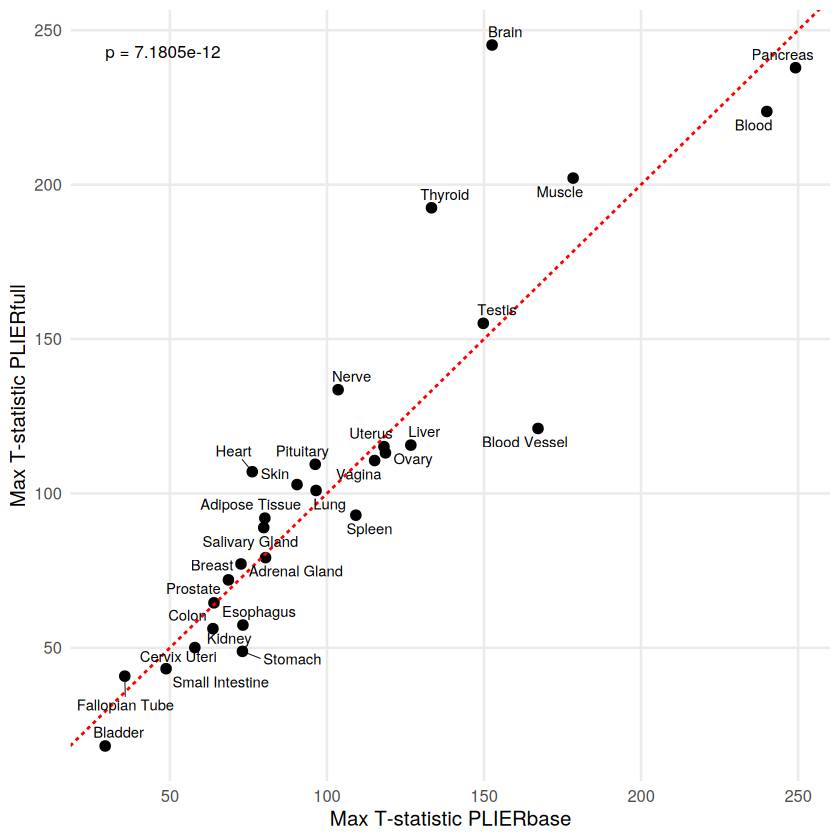

In [5]:
# Correlation Pearson 

ct <- cor.test(res_join$abs_t_base, res_join$abs_t_full, method = "pearson")
p_txt1 <- sprintf("p = %.5g", ct$p.value)
min_x  <- min(res_join$abs_t_base, na.rm = TRUE)
max_y  <- max(res_join$abs_t_full, na.rm = TRUE)

ggplot(res_join, aes(x = abs_t_base, y = abs_t_full)) +
  geom_point(size = 2.2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", linewidth = 0.6, color = "red") +
  geom_text_repel(aes(label = SMTS), size = 3, max.overlaps = Inf,
                  box.padding = 0.25, segment.size = 0.2) +
  annotate("text", x = min_x, y = max_y, label = p_txt1,
           hjust = 0, vjust = 1, size = 3.5) +
  labs(
    x = "Max T-statistic PLIERbase",
    y = "Max T-statistic PLIERfull"
  ) +
  theme_minimal(base_size = 12) +
  theme(plot.title = element_text(face = "bold", size = 13),
        panel.grid.minor = element_blank())

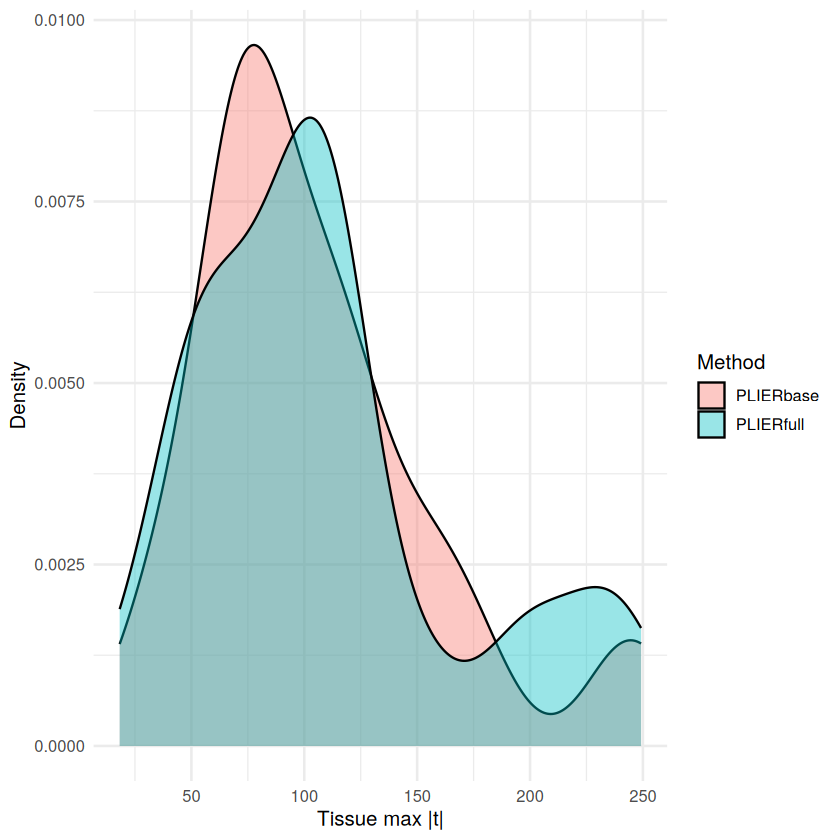

In [6]:
# Distributions max |t| 

pt <- t.test(res_join$abs_t_full, res_join$abs_t_base, paired = TRUE)

res_long <- res_join %>%
  select(SMTS, abs_t_base, abs_t_full) %>%
  pivot_longer(c(abs_t_base, abs_t_full),
               names_to = "method", values_to = "abs_t") %>%
  mutate(method = recode(method, abs_t_base = "PLIERbase", abs_t_full = "PLIERfull"))

xmax <- max(res_long$abs_t, na.rm = TRUE)
ymax <- ggplot_build(
  ggplot(res_long, aes(x = abs_t, fill = method)) + geom_density()
)$data[[1]]$y |> max(na.rm = TRUE)

ggplot(res_long, aes(x = abs_t, fill = method)) +
  geom_density(alpha = 0.4, adjust = 1) +
  labs(x = "Tissue max |t|", y = "Density",
       fill = "Method") +
  theme_minimal(base_size = 12)

# CLAMP vs PLIER

In [7]:
plier_gtex <- readRDS(here('output/gtex/gtex_PLIER.rds'))

In [9]:
head(plier_gtex$B)

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
"1,Cells - EBV-transformed Lymphocytes Male 40-49 Up",0.46617279,-0.160274908,0.73189638,0.03673337,-0.16036737,0.27011287,0.34155448,0.18709101,0.124303805,0.17580335,⋯,-0.23524018,-0.04565981,0.192526401,-0.07712182,0.18866958,0.49366655,0.083557804,0.34700683,-0.3813536716,0.23392498
"2,Colon - Transverse Male 70-79 Up",-0.05482741,0.031944407,-0.07119695,-0.03778371,0.07130929,-0.03862763,-0.10123493,-0.01607100,-0.094175281,-0.04041773,⋯,0.03768582,0.01823106,-0.086882211,0.19412630,0.28690821,-0.08885060,0.038956649,-0.06684843,0.0695568037,-0.04009313
LV 3,-0.18970150,0.084744719,-0.04421499,-0.12689688,-0.01891176,-0.03325522,-0.20798620,0.89332084,-0.003713821,0.04296174,⋯,-0.01377714,-0.08280761,0.009087268,0.09793773,0.05386236,-0.19782578,0.423212881,0.07848064,-0.0234689283,-0.05235816
"4,Whole Blood Female 50-59 Up",-0.16835215,-0.005646782,-0.14882507,-0.13028856,0.04456463,-0.14427548,-0.09085780,-0.08721934,-0.070949456,-0.13710315,⋯,0.02282449,-0.16052529,-0.080124805,-0.05021261,-0.11735479,-0.09932323,-0.088999635,-0.05632542,0.0002726316,-0.06148682
"5,Myc Targets V1",0.22784539,0.135854387,0.02489118,0.14955940,-0.35129585,0.06705728,0.04226745,0.15924572,0.305569910,0.14872014,⋯,-0.19613522,0.17144165,-0.187114670,-0.06161684,0.01157285,0.04681580,0.413042999,-0.09198360,0.2846712048,0.04444101
LV 6,-0.14773172,-0.090280367,-0.09726386,-0.17305484,-0.10486026,-0.16211997,-0.24268387,-0.18460777,-0.137521121,-0.15737880,⋯,0.05857534,0.05339165,0.067576095,0.03867730,0.09123170,0.09281796,0.009773036,0.06410904,0.0467131491,0.09168696


In [17]:
plier_gtex_B <- data.frame(plier_gtex$B)

rownames(plier_gtex_B) <- paste0('LV', seq_along(rownames(plier_gtex_B)))
head(plier_gtex_B)

,GTEX.1117F.0226.SM.5GZZ7,GTEX.1117F.0426.SM.5EGHI,GTEX.1117F.0526.SM.5EGHJ,GTEX.1117F.0626.SM.5N9CS,GTEX.1117F.0726.SM.5GIEN,GTEX.1117F.1326.SM.5EGHH,GTEX.1117F.2426.SM.5EGGH,GTEX.1117F.2526.SM.5GZY6,GTEX.1117F.2826.SM.5GZXL,GTEX.1117F.2926.SM.5GZYI,⋯,GTEX.ZZPU.1126.SM.5N9CW,GTEX.ZZPU.1226.SM.5N9CK,GTEX.ZZPU.1326.SM.5GZWS,GTEX.ZZPU.1426.SM.5GZZ6,GTEX.ZZPU.1826.SM.5E43L,GTEX.ZZPU.2126.SM.5EGIU,GTEX.ZZPU.2226.SM.5EGIV,GTEX.ZZPU.2426.SM.5E44I,GTEX.ZZPU.2626.SM.5E45Y,GTEX.ZZPU.2726.SM.5NQ8O
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LV1,0.46617279,-0.160274908,0.73189638,0.03673337,-0.16036737,0.27011287,0.34155448,0.18709101,0.124303805,0.17580335,⋯,-0.23524018,-0.04565981,0.192526401,-0.07712182,0.18866958,0.49366655,0.083557804,0.34700683,-0.3813536716,0.23392498
LV2,-0.05482741,0.031944407,-0.07119695,-0.03778371,0.07130929,-0.03862763,-0.10123493,-0.01607100,-0.094175281,-0.04041773,⋯,0.03768582,0.01823106,-0.086882211,0.19412630,0.28690821,-0.08885060,0.038956649,-0.06684843,0.0695568037,-0.04009313
LV3,-0.18970150,0.084744719,-0.04421499,-0.12689688,-0.01891176,-0.03325522,-0.20798620,0.89332084,-0.003713821,0.04296174,⋯,-0.01377714,-0.08280761,0.009087268,0.09793773,0.05386236,-0.19782578,0.423212881,0.07848064,-0.0234689283,-0.05235816
LV4,-0.16835215,-0.005646782,-0.14882507,-0.13028856,0.04456463,-0.14427548,-0.09085780,-0.08721934,-0.070949456,-0.13710315,⋯,0.02282449,-0.16052529,-0.080124805,-0.05021261,-0.11735479,-0.09932323,-0.088999635,-0.05632542,0.0002726316,-0.06148682
LV5,0.22784539,0.135854387,0.02489118,0.14955940,-0.35129585,0.06705728,0.04226745,0.15924572,0.305569910,0.14872014,⋯,-0.19613522,0.17144165,-0.187114670,-0.06161684,0.01157285,0.04681580,0.413042999,-0.09198360,0.2846712048,0.04444101
LV6,-0.14773172,-0.090280367,-0.09726386,-0.17305484,-0.10486026,-0.16211997,-0.24268387,-0.18460777,-0.137521121,-0.15737880,⋯,0.05857534,0.05339165,0.067576095,0.03867730,0.09123170,0.09281796,0.009773036,0.06410904,0.0467131491,0.09168696


In [ ]:
clamp_gtex <- readRDS(here('output/gtex/gtex_PLIER2.rds'))

In [13]:
clamp_gtex_B <- clamp_gtex$B
head(clamp_gtex$B)

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
LV1,-0.001996071,-0.17177932,0.37175520,0.29630823,0.0417361423,-0.17759329,0.06224892,-0.133085952,-0.128990027,-0.10360368,⋯,0.12990498,-0.07878671,0.13234024,-0.10201980,-0.04368834,0.233400836,-0.218585487,0.67890371,-0.20314197,0.011847403
LV2,-0.007366913,-0.07904385,-0.06618871,0.02950967,0.0137848493,0.05256078,0.03923502,0.041920420,0.039229944,0.02928616,⋯,-0.03298658,-0.05153172,-0.02177846,-0.04186566,-0.04859947,-0.100795907,-0.005755683,-0.09678039,-0.06160179,-0.024521240
LV3,-0.027424993,-0.12991085,0.26623758,0.08792828,0.3045879024,0.87754667,-0.02713904,0.083964878,0.228213808,-0.13788913,⋯,0.01803576,-0.03783572,0.44882181,0.30492352,-0.01831873,0.003157641,-0.007765243,-0.04482186,-0.11218835,0.167161654
LV4,-0.032972727,-0.01279773,-0.03832356,-0.04645557,-0.0265536246,0.02759365,-0.03862814,-0.072075046,-0.072642116,-0.02687103,⋯,-0.03048997,-0.05856136,-0.03930446,-0.02803328,-0.05697038,-0.139670789,-0.050308190,-0.07187161,-0.01218328,-0.043234313
LV5,-0.237416460,-0.05128643,-0.32621112,-0.17729015,0.0005296356,-0.14077236,-0.13892438,0.109910412,-0.141782781,-0.11271587,⋯,0.23718304,0.14859859,0.08486135,0.04298099,-0.05112148,-0.065985270,0.077490913,-0.21585592,0.28854279,-0.083955540
LV6,0.113137912,-0.02838519,0.09060313,0.03817960,-0.1309868726,-0.08703183,0.08357237,-0.008223451,0.000362112,-0.06311435,⋯,-0.13731111,-0.08775167,0.04220346,-0.11842065,-0.05654503,0.010828251,-0.126906181,-0.02506434,-0.12540800,-0.005404993


# A tibble: 108 × 10
   method tissue    LV    t_stat p_value  n_in n_out mean_in mean_out t_stat_abs
   <chr>  <chr>     <chr>  <dbl>   <dbl> <dbl> <dbl>   <dbl>    <dbl>      <dbl>
 1 CLAMP  Cells - … LV194  -277.       0   504 16878  -0.555  0.0166        277.
 2 CLAMP  Pancreas  LV25    251.       0   328 17054   1.51  -0.0290        251.
 3 CLAMP  Whole Bl… LV187  -241.       0   755 16627  -0.679  0.0308        241.
 4 CLAMP  Cells - … LV187  -230.       0   174 17208  -0.825  0.00835       230.
 5 CLAMP  Brain - … LV199   180.       0   241 17141   0.484 -0.00680       180.
 6 CLAMP  Thyroid   LV195   169.       0   653 16729   1.01  -0.0394        169.
 7 CLAMP  Skin - S… LV169   160.       0   701 16681   1.42  -0.0597        160.
 8 CLAMP  Testis    LV76    158.       0   361 17021   1.97  -0.0418        158.
 9 CLAMP  Muscle -… LV47    154.       0   803 16579   1.09  -0.0526        154.
10 CLAMP  Skin - N… LV169   149.       0   604 16778   1.49  -0.0538        149.
# ℹ 98 

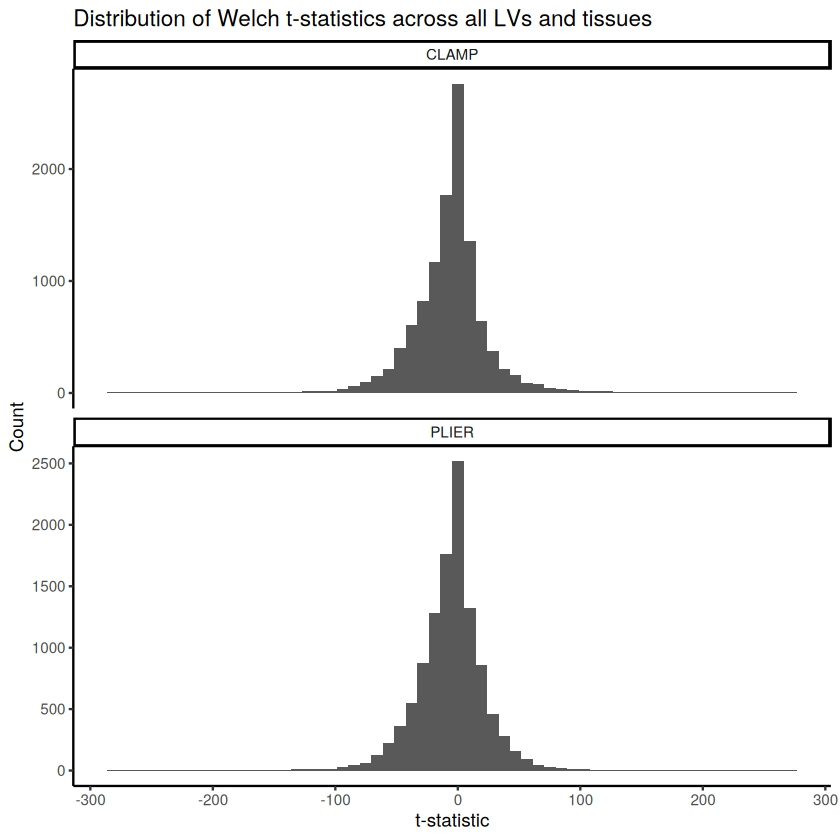

In [ ]:
calc_t <- function(x_in, x_out) {
  if (sum(!is.na(x_in)) < 2 || sum(!is.na(x_out)) < 2) return(c(stat = NA_real_, p = NA_real_))
  wt <- try(stats::wilcox.test(x_in, x_out), silent = TRUE)
  if (inherits(wt, "try-error")) return(c(stat = NA_real_, p = NA_real_))
  c(stat = unname(wt$statistic), p = wt$p.value)
}
